In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Generate dataset

In [91]:
# np.random.seed(42)

# n_users = 100
# n_items = 20

# min_taken, max_taken = 3, 12
# ratings = np.zeros((n_users, n_items), dtype=int)
# for u in range(n_users):
#     taken_count = np.random.randint(min_taken, max_taken+1)
#     taken_items = np.random.choice(n_items, size=taken_count, replace=False)
#     # assign ratings 1-5
#     ratings[u, taken_items] = np.random.randint(1, 6, size=taken_count)

# # Convert to DataFrame for readability
# course_cols = [f"course_{i}" for i in range(n_items)]
# users_idx = [f"user_{i}" for i in range(n_users)]
# ratings_df = pd.DataFrame(ratings, index=users_idx, columns=course_cols)

### Load DataSet

In [92]:
# ratings_df = pd.read_csv("../real_data/user_course_ratings.csv", index_col=0)
ratings_df = pd.read_csv("../gpt_generated_data/user_course_ratings_realistic.csv", index_col=0)
ratings = ratings_df.values

### Store in NumPy array and compute averages

In [93]:
def row_average_ignore_zeros(mat):
    sums = mat.sum(axis=1)
    counts = (mat != 0).sum(axis=1)

    return np.where(counts>0, sums / counts, 0), counts

def col_average_ignore_zeros(mat):
    sums = mat.sum(axis=0)
    counts = (mat != 0).sum(axis=0)
    return np.where(counts>0, sums / counts, 0), counts

user_avg, user_counts = row_average_ignore_zeros(ratings)
course_avg, course_counts = col_average_ignore_zeros(ratings)

# user_avg_series = pd.Series(user_avg, index=users_idx, name="user_avg")
user_avg_series = pd.Series(user_avg, name="user_avg")
# course_avg_series = pd.Series(course_avg, index=course_cols, name="course_avg")
course_avg_series = pd.Series(course_avg, name="course_avg")

### Recommendation system implementations

In [ ]:
def cosine_similarity_matrix(mat):
    # mat: rows = entities (users or items), columns = features
    # compute normalized vectors, handle zero-norms
    norms = np.linalg.norm(mat, axis=1)
    safe_norms = np.where(norms==0, 1, norms)  # avoid division by zero
    normed = mat / safe_norms[:, None]
    sim = normed @ normed.T
    # clip numerical errors
    sim = np.clip(sim, -1.0, 1.0)
    return sim
    
def recommend_user_based(train_mat, target_user_idx, k_neighbors=5, n_recommend=5):
    # compute cosine similarity between users
    sim = cosine_similarity_matrix(train_mat)
    # exclude self
    sim[target_user_idx, target_user_idx] = -1
    neighbors_idx = np.argsort(sim[target_user_idx])[::-1][:k_neighbors]

    # Similarity row for user 0
    user0_sim = sim[0]


    # items rated by neighbors but not by target
    target_taken = train_mat[target_user_idx] != 0
    candidate_scores = {}
    for ni in neighbors_idx:
        neighbor_ratings = train_mat[ni]
        for course_idx, r in enumerate(neighbor_ratings):
            if r != 0 and not target_taken[course_idx]:
                candidate_scores.setdefault(course_idx, []).append((r, sim[target_user_idx, ni]))


    # print(np.argsort(sim[target_user_idx])[-5:][::-1])
    print(sim[target_user_idx][neighbors_idx])



    # aggregate scores (weighted average by similarity)
    predicted = []
    for course, vals in candidate_scores.items():
        # vals: list of (rating, similarity_to_target)
        weights = np.array([s for _, s in vals])
        ratings_list = np.array([rat for rat, _ in vals])
        # if all weights sum to 0 (unlikely), fallback to simple average
        if weights.sum() == 0:
            score = ratings_list.mean()
        else:
            score = (ratings_list * weights).sum() / weights.sum()
        predicted.append((course, score))
    predicted.sort(key=lambda x: x[1], reverse=True)
    recs = predicted[:n_recommend]
    return recs, neighbors_idx

def recommend_course_based(train_mat, target_user_idx, n_recommend=5):
    # items are columns; compute course-course cosine similarity (items x items)
    course_mat = train_mat.T  # now rows are items
    sim_items = cosine_similarity_matrix(course_mat)
    user_ratings = train_mat[target_user_idx]
    taken_mask = user_ratings != 0
    candidate_scores = {}
    
    for course_idx in range(course_mat.shape[0]):
        if taken_mask[course_idx]:
            continue  # skip items already taken
        # consider all items the user rated; prediction = weighted sum of user's ratings * similarity
        rated_indices = np.where(taken_mask)[0]
        if rated_indices.size == 0:
            continue
        sims = sim_items[course_idx, rated_indices]
        user_r = user_ratings[rated_indices]
        # weighted prediction
        if np.abs(sims).sum() == 0:
            pred = np.mean(user_r)
        else:
            pred = (sims * user_r).sum() / np.abs(sims).sum()
        candidate_scores[course_idx] = pred

    predicted = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)
    return predicted[:n_recommend], sim_items


### Quality evaluation: create train/test split (80/20 of observed ratings)

In [95]:
def train_test_split_ratings(mat, test_ratio=0.2, seed=1):
    np.random.seed(seed)
    train = mat.copy()
    test = np.zeros_like(mat)
    for u in range(mat.shape[0]):
        rated_indices = np.where(mat[u] != 0)[0]
        if rated_indices.size == 0:
            continue
        n_test = max(1, int(np.floor(test_ratio * rated_indices.size)))
        test_idx = np.random.choice(rated_indices, size=n_test, replace=False)
        train[u, test_idx] = 0
        test[u, test_idx] = mat[u, test_idx]
    return train, test

train_mat, test_mat = train_test_split_ratings(ratings, test_ratio=0.2, seed=42)

# Precision and recall for k=5 recommendations averaged across users
def precision_recall_at_k(train_mat, test_mat, k=5, method="user", k_neighbors=5):
    n_users = train_mat.shape[0]
    precisions = []
    recalls = []
    for u in range(n_users):
        # generate recommendations based on train_mat
        if method == "user":
            recs, _ = recommend_user_based(train_mat, u, k_neighbors=k_neighbors, n_recommend=k)
        else:
            recs, _ = recommend_course_based(train_mat, u, n_recommend=k)
        recommended_items = [course for course, _ in recs]
        test_positives = np.where(test_mat[u] != 0)[0]
        if test_positives.size == 0:
            # skip users with no test positives when computing averages
            continue
        hits = np.intersect1d(recommended_items, test_positives)
        precision = hits.size / k
        recall = hits.size / test_positives.size
        precisions.append(precision)
        recalls.append(recall)
    # Return average metrics (and counts of users used)
    if len(precisions) == 0:
        return 0.0, 0.0, 0
    return float(np.mean(precisions)), float(np.mean(recalls)), len(precisions)

# Evaluate both methods
prec_user, rec_user, users_used_user = precision_recall_at_k(train_mat, test_mat, k=5, method="user", k_neighbors=5)
prec_course, rec_course, users_used_course = precision_recall_at_k(train_mat, test_mat, k=5, method="course")

[42  8 55 88 67]
[85 60 52 28 99]
[75 64 76 33 11]
[32 99 97 94 68]
[40 27  6 33 53]
[90 49 52 34 80]
[19 14  8 69  4]
[18 98 87 89 24]
[67 26  0 42 49]
[91 24 56 16 37]
[71 84 96 56 41]
[39 59 96 92 95]
[99 46 73 19 76]
[65 30 22 48 33]
[95 77 30 20 31]
[66 98 64 34 46]
[83 56 75 20 25]
[61 19 94 97  3]
[ 7 38 25 98 94]
[42 23 77 49 53]
[95 31 67 14 35]
[96 84 14 57 43]
[65 93 90 56 13]
[99 19 49 53 58]
[83 75  7  9 16]
[38 50 81 32 18]
[ 8 67 37 44 93]
[33 69 53  4 90]
[55 49 85  1 35]
[47 39 92 94 11]
[14 77 31 13 95]
[95 20 14 30 50]
[94 20 25  3 95]
[27 61 92  4 46]
[79 90 15  5 66]
[95 55 20 31 14]
[91 25 10 30 38]
[26 67  8 74 44]
[25 81 18 92 63]
[11 29 92 94 89]
[ 4 27 92 46 33]
[43 93 10 82 21]
[ 0 77 95 55 19]
[58 41 35 95 98]
[26  8 37  5 49]
[69  6 80 84 87]
[15 53 92 12 33]
[29 98 50 89 25]
[13 71 10 64  2]
[ 5 28 73  8 19]
[31 25 47 89 59]
[96 92 82 39 33]
[90 85  5  1 54]
[19 27 23 46 42]
[85 66 52 99 15]
[35 88 95 28 42]
[65 22 16 10 98]
[96 21 72 82 27]
[43 74 23 49 4

### Visualization: plot bar chart of top-5 items recommended for a specific user

In [96]:
target_user = 0
user_recs, neighbors = recommend_user_based(train_mat, target_user, k_neighbors=5, n_recommend=5)
course_recs, course_sim = recommend_course_based(train_mat, target_user, n_recommend=5)

# Prepare DataFrame of recommendations to show
def recs_to_df(recs):
    return pd.DataFrame([{"course": f"course_{course}", "predicted_score": float(score)} for course, score in recs])

user_recs_df = recs_to_df(user_recs)
course_recs_df = recs_to_df(course_recs)

# Display several outputs
print("=== Ratings matrix (first 5 users) ===")
display(ratings_df.head(5))
print("\n=== User average ratings (first 5 users) ===")
display(user_avg_series.head(5))
print("\n=== Top 5 courses by average rating (global) ===")
display(course_avg_series.sort_values(ascending=False).head(5))
print("\n=== Example: target user (user_0) - their ratings ===")
display(pd.DataFrame(ratings_df.loc["user_0"]).T)
print(f"\n=== User-based CF recommendations for user_{target_user} (top-5) ===")
display(user_recs_df)
print(f"\n=== course-based CF recommendations for user_{target_user} (top-5) ===")
display(course_recs_df)

print(f"\nPrecision@5 (user-based CF): {prec_user:.4f}  | Recall@5: {rec_user:.4f}  | evaluated_users: {users_used_user}")
print(f"Precision@5 (course-based CF): {prec_course:.4f}  | Recall@5: {rec_course:.4f}  | evaluated_users: {users_used_course}")

# Return some objects for potential further inspection
# ratings_df_head, user_avg_head, course_avg_head, user_recs_df, course_recs_df, (prec_user, rec_user), (prec_course, rec_course)


[42  8 55 88 67]
=== Ratings matrix (first 5 users) ===


,course_0,course_1,course_2,course_3,course_4,course_5,course_6,course_7,course_8,course_9,course_10,course_11,course_12,course_13,course_14,course_15,course_16,course_17,course_18,course_19
user_id,,,,,,,,,,,,,,,,,,,,
user_0,0,0,0,3,0,3,0,0,3,4,0,4,0,2,0,4,0,0,0,0
user_1,0,2,0,0,0,4,0,3,4,0,0,3,0,0,0,0,0,0,0,0
user_2,3,4,0,0,1,0,0,2,0,0,0,0,0,3,3,0,0,0,0,0
user_3,0,0,0,0,0,0,3,2,0,3,4,0,0,0,0,0,0,5,0,0
user_4,0,0,4,0,0,0,0,0,4,0,0,0,3,3,0,0,0,0,4,0



=== User average ratings (first 5 users) ===


0    3.285714
1    3.200000
2    2.666667
3    3.400000
4    3.600000
Name: user_avg, dtype: float64


=== Top 5 courses by average rating (global) ===


17    4.617647
19    4.481481
10    4.421053
11    4.090909
14    4.033333
Name: course_avg, dtype: float64


=== Example: target user (user_0) - their ratings ===


,course_0,course_1,course_2,course_3,course_4,course_5,course_6,course_7,course_8,course_9,course_10,course_11,course_12,course_13,course_14,course_15,course_16,course_17,course_18,course_19
user_0,0,0,0,3,0,3,0,0,3,4,0,4,0,2,0,4,0,0,0,0



=== User-based CF recommendations for user_0 (top-5) ===


,course,predicted_score
0,course_19,4.466337
1,course_2,3.000000
2,course_1,3.000000
3,course_6,3.000000
4,course_0,2.539758



=== course-based CF recommendations for user_0 (top-5) ===


,course,predicted_score
0,course_0,3.487771
1,course_10,3.434123
2,course_4,3.415769
3,course_12,3.405789
4,course_19,3.393860



Precision@5 (user-based CF): 0.0720  | Recall@5: 0.3100  | evaluated_users: 100
Precision@5 (course-based CF): 0.0760  | Recall@5: 0.3200  | evaluated_users: 100


### Bar chart for user-based recommendations (top-5)

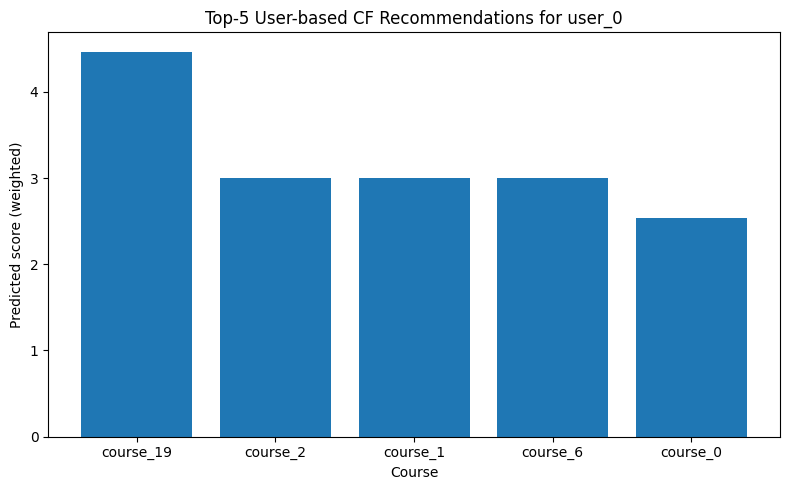

In [97]:
plt.figure(figsize=(8,5))
courses = [r['course'] for r in user_recs_df.to_dict('records')]
scores = user_recs_df['predicted_score'].values
plt.bar(courses, scores)
plt.title("Top-5 User-based CF Recommendations for user_0")
plt.xlabel("Course")
plt.ylabel("Predicted score (weighted)")
plt.tight_layout()
plt.show()

### Course-Based bar chart

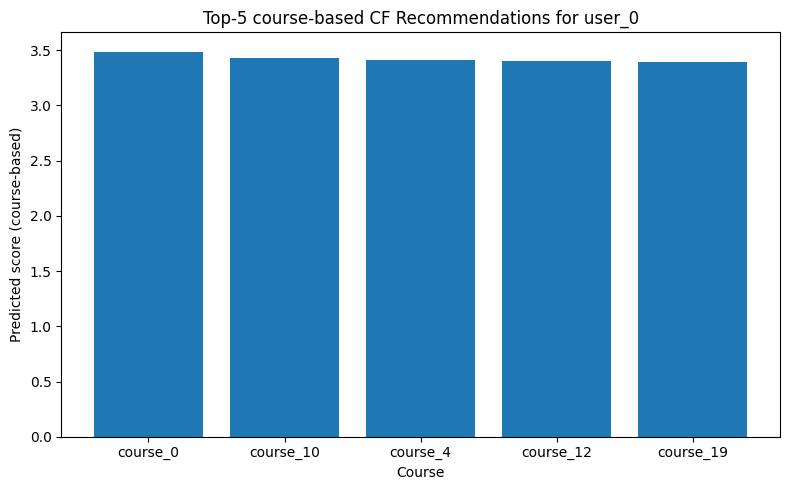

In [98]:
plt.figure(figsize=(8,5))
courses_i = [r['course'] for r in course_recs_df.to_dict('records')]
scores_i = course_recs_df['predicted_score'].values
plt.bar(courses_i, scores_i)
plt.title("Top-5 course-based CF Recommendations for user_0")
plt.xlabel("Course")
plt.ylabel("Predicted score (course-based)")
plt.tight_layout()
plt.show()